<a href="https://colab.research.google.com/github/dominikjagoda/my-first/blob/main/DeepLearningPracadomowa6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.utils.vis_utils import plot_model
from IPython.display import Image 
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

# install optuna
! pip install optuna

import optuna


batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)

     |████████████████████████████████| 286kB 11.3MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 163kB 26.2MB/s 
     |████████████████████████████████| 133kB 27.1MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 112kB 33.6MB/s 
     |████████████████████████████████| 481kB 31.8MB/s 
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=a7363292803826dee1aa8dfbd5dc081382b77b832b45c51916330fcff45245b0
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=eeb419690b5db010e64e469edfa6a8395ebc1151aa8b47dd709144398ad4ebf9
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sh

In [ ]:
N_TRAIN_EXAMPLES = 1000 #3000
N_TEST_EXAMPLES = 10000
x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

In [ ]:
def c_model():
  # Our old fully connected (dense) network
  #model = Sequential()
  #model.add(Dense(512, activation='relu', input_shape=(784,)))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Dense(num_classes, activation='softmax'))
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [ ]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  zoom_range=trial.suggest_uniform('zoom_range', .00,0.30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  
  datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

  model = c_model()

  from keras.callbacks import EarlyStopping

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  e_s=EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)

  history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(x_test, y_test), 
                    callbacks=[e_s])

  score = model.evaluate(x_test, y_test,verbose=0)

  return score[1]

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30, timeout=1200)

[I 2021-01-25 19:32:49,487] A new study created in memory with name: no-name-882e262c-f338-47c6-a7b3-b074f3ac3402
[I 2021-01-25 19:40:53,127] Trial 0 finished with value: 0.9495999813079834 and parameters: {'rotation_range': 2.360083078537772, 'zoom_range': 0.06714682319786654, 'shift_range': 0.16030191648284509}. Best is trial 0 with value: 0.9495999813079834.
[I 2021-01-25 19:48:57,777] Trial 1 finished with value: 0.9711999893188477 and parameters: {'rotation_range': 23.344758002573275, 'zoom_range': 0.07967920677850743, 'shift_range': 0.038826648257993784}. Best is trial 1 with value: 0.9711999893188477.
[I 2021-01-25 19:57:04,108] Trial 2 finished with value: 0.9775999784469604 and parameters: {'rotation_range': 12.929645068556962, 'zoom_range': 0.1658624191791468, 'shift_range': 0.07741374169558933}. Best is trial 2 with value: 0.9775999784469604.


In [ ]:
print("Number trials: {}".format(len(study.trials)))
print("Best trial:")
trial=study.best_trial
print("Value: {}".format(trial.value))
print("Params")
for key, value in trial.params.items():
  print("  {}:{}  ".format(key, value))

Number trials: 3
Best trial:
Value: 0.9775999784469604
Params
  rotation_range:12.929645068556962  
  zoom_range:0.1658624191791468  
  shift_range:0.07741374169558933  


In [ ]:
rotation_range=trial.params.get('rotation_range')
zoom_range=trial.params.get('zoom_range')
shift_range=trial.params.get('shift_range')

  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=zoom_range
    )

model = c_model()

from keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

e_s=EarlyStopping(monitor='val_accuracy',patience=12,verbose=1)

history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[e_s])

Epoch 1/50
8/8 [==============================] - 10s 1s/step - loss: 2.2932 - accuracy: 0.1399 - val_loss: 2.1589 - val_accuracy: 0.3131
Epoch 2/50
8/8 [==============================] - 10s 1s/step - loss: 2.1321 - accuracy: 0.2789 - val_loss: 1.5359 - val_accuracy: 0.5701
Epoch 3/50
8/8 [==============================] - 10s 1s/step - loss: 1.7669 - accuracy: 0.4089 - val_loss: 1.0206 - val_accuracy: 0.7192
Epoch 4/50
8/8 [==============================] - 10s 1s/step - loss: 1.4546 - accuracy: 0.5069 - val_loss: 0.6366 - val_accuracy: 0.8397
Epoch 5/50
8/8 [==============================] - 10s 1s/step - loss: 1.2299 - accuracy: 0.5820 - val_loss: 0.5071 - val_accuracy: 0.8584
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.9664 - accuracy: 0.6811 - val_loss: 0.3945 - val_accuracy: 0.8809
Epoch 7/50
8/8 [==============================] - 10s 1s/step - loss: 0.8081 - accuracy: 0.7471 - val_loss: 0.2949 - val_accuracy: 0.9186
Epoch 8/50
8/8 [==================

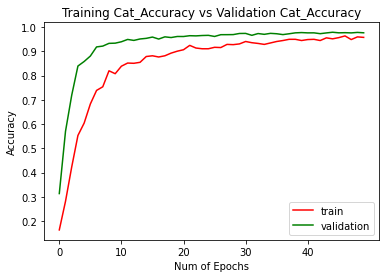

In [ ]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])

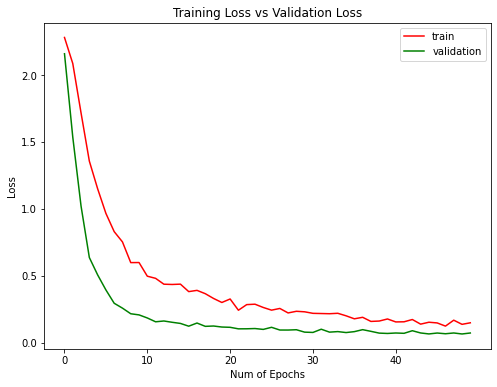

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

(1000, 28, 28)


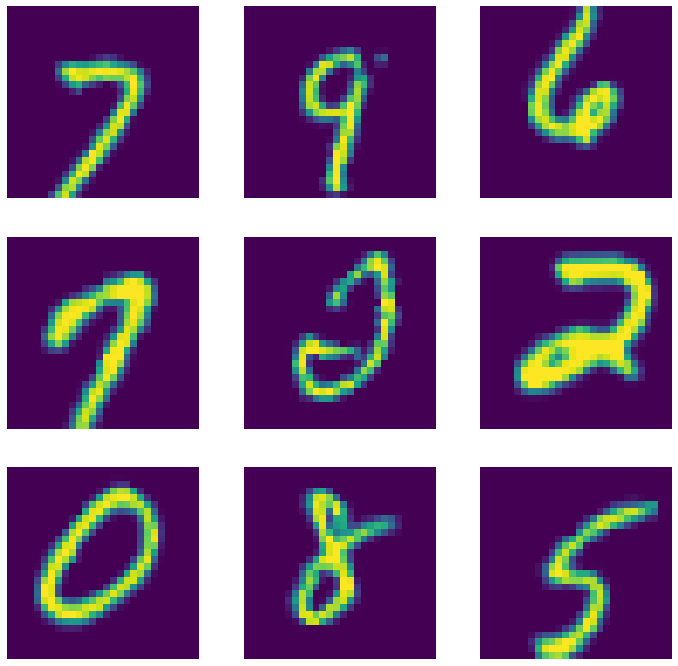

In [ ]:
print(x_train.reshape((len(x_train),img_rows, img_cols)).shape)
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].reshape((img_rows, img_cols)))
         plt.axis('off')
    plt.show()
    break

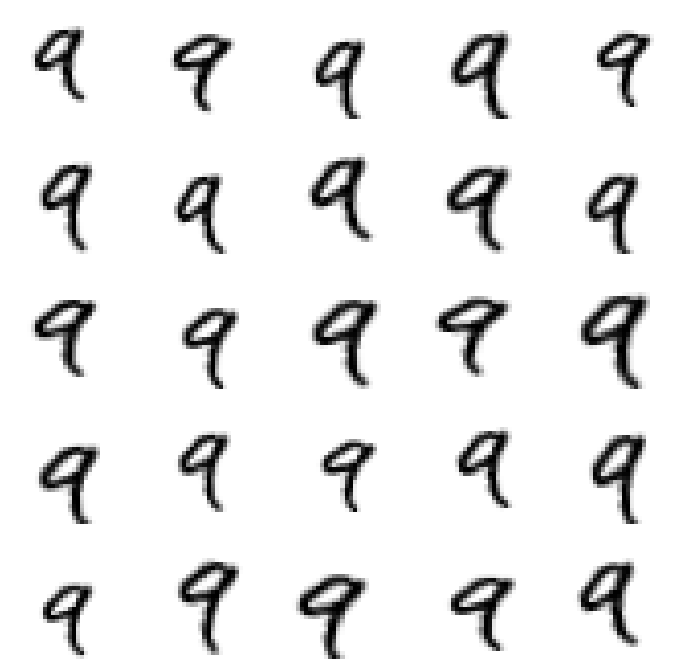

In [ ]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[4:6], y_train[4:6], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].reshape((img_rows, img_cols)), cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

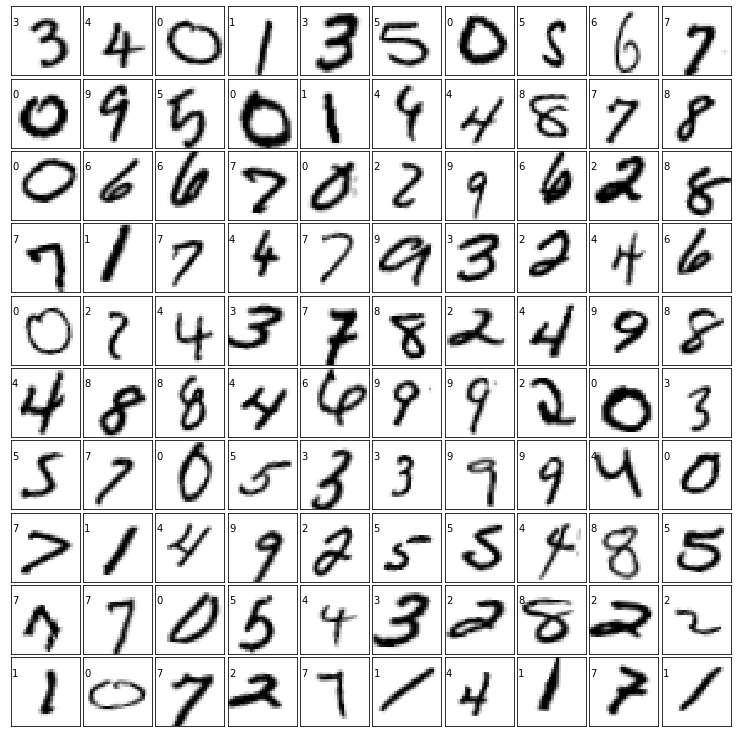

In [ ]:
#visualize the digits
fig = plt.figure(figsize=(10, 10)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# generate augmented plot
X_train, Y_train = datagen.flow(x_train,y_train, batch_size=100).next()
for i in range(100):
  ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(X_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
  # label the image with the target value
  ax.text(0, 7, str(np.argmax(Y_train[i])))

In [ ]:
# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% " % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 99.60% , Test: 97.69% 


In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

313/313 - 7s
[[ 969    0    3    0    1    0    4    1    2    0]
 [   1 1108    3    1    0    1    2    4   15    0]
 [   1    0 1025    1    0    0    1    1    3    0]
 [   0    0    1  993    0    7    0    2    6    1]
 [   1    1    1    0  930    0    6    0    2   41]
 [   0    1    0    4    0  869    2    1   12    3]
 [   1    4    0    0    1    2  946    0    4    0]
 [   1    1   17    2    2    0    0  992    2   11]
 [  11    0    2    0    0    1    1    0  953    6]
 [   2    0    0    0    4    5    1    4    9  984]]


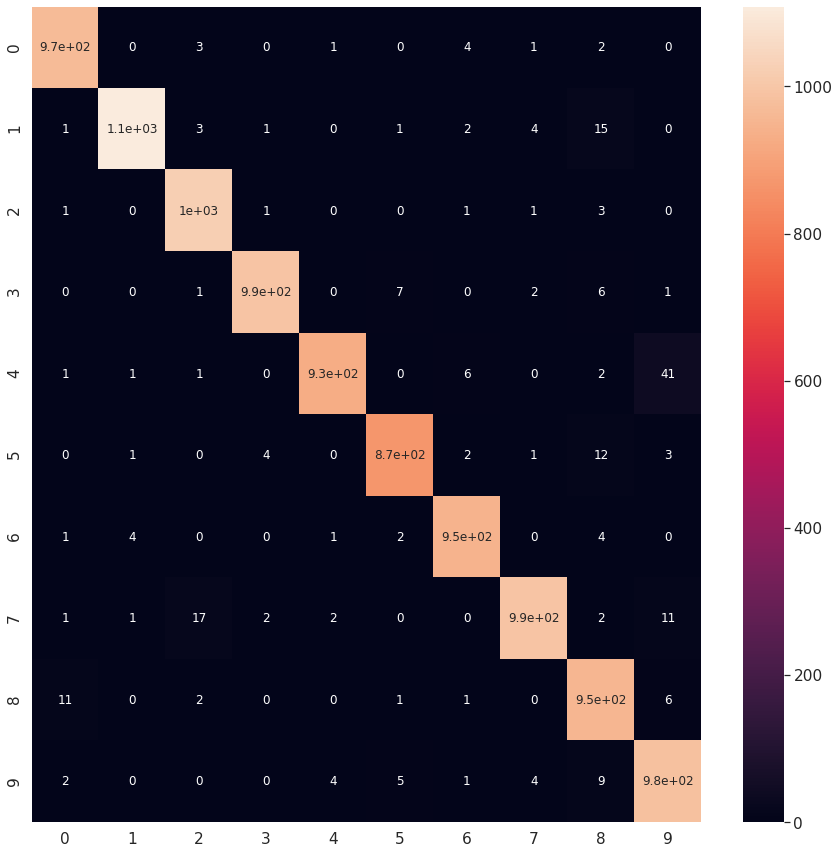

In [ ]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

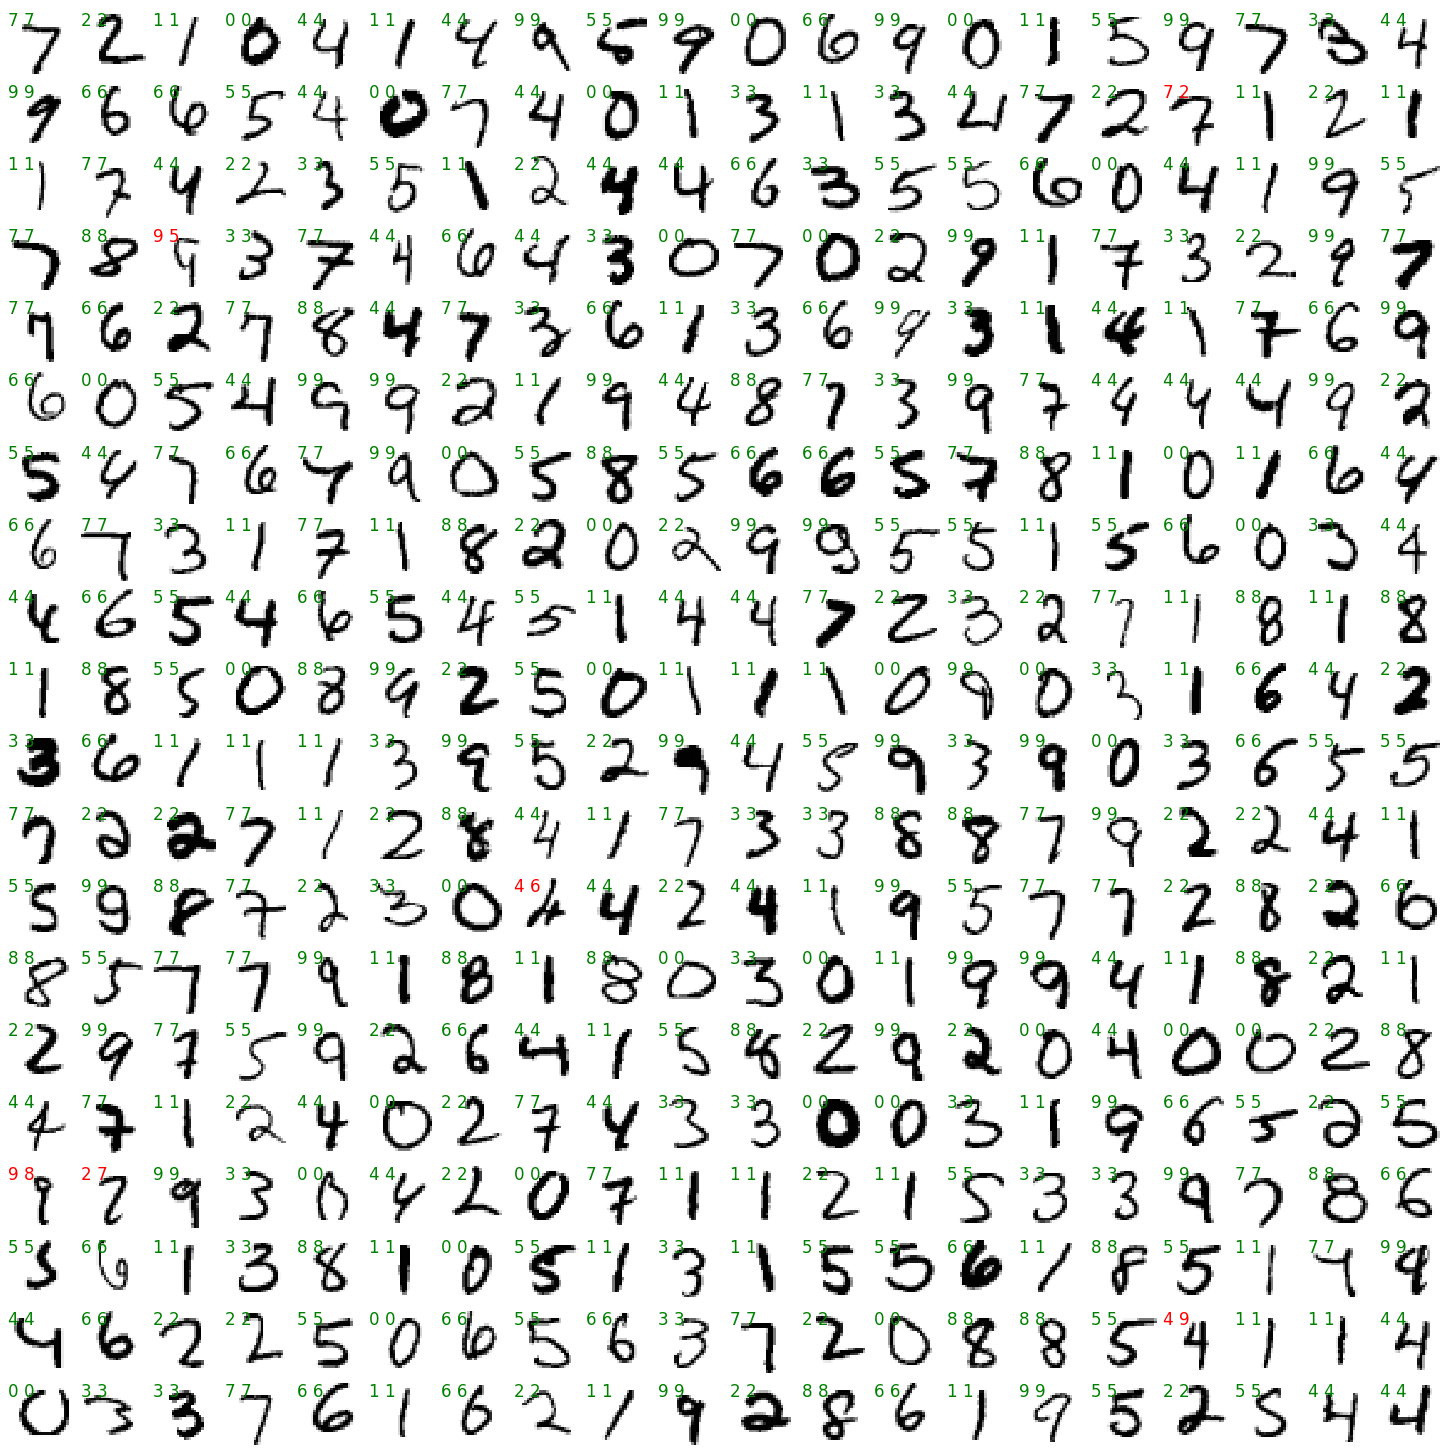

In [16]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

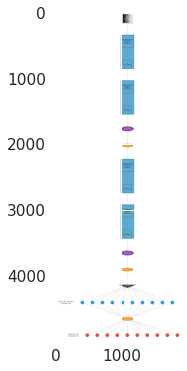

In [17]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
imgplot = plt.imshow(img,)
plt.show()